The file contains the training and testing of JabRef
The remaining models were trained by the other members of the group. 

The way the models were distributed are

BB49B3789EC2F1C13237 - JabRef

B494E26228A0547AA54C - Blogs

D5036AFB177566430360 - MyVolts


In [1]:
import numpy as np
import pandas as pd

# Vizualisation
import matplotlib.pyplot as plt
import missingno

from sklearn import preprocessing
import catboost, lightgbm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model, cross_validation
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier,  RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier

C:\Users\Dhruv\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Dhruv\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv('./JabRef_train.csv')
test = pd.read_csv('./JabRef_test.csv')
output_file = pd.read_csv('./output_JabRef.csv')

C:\Users\Dhruv\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train['set_clicked'].value_counts()

0    264700
1      5546
Name: set_clicked, dtype: int64

In [4]:
train = train.replace(r'\N', np.nan)
test = test.replace(r'\N', np.nan)

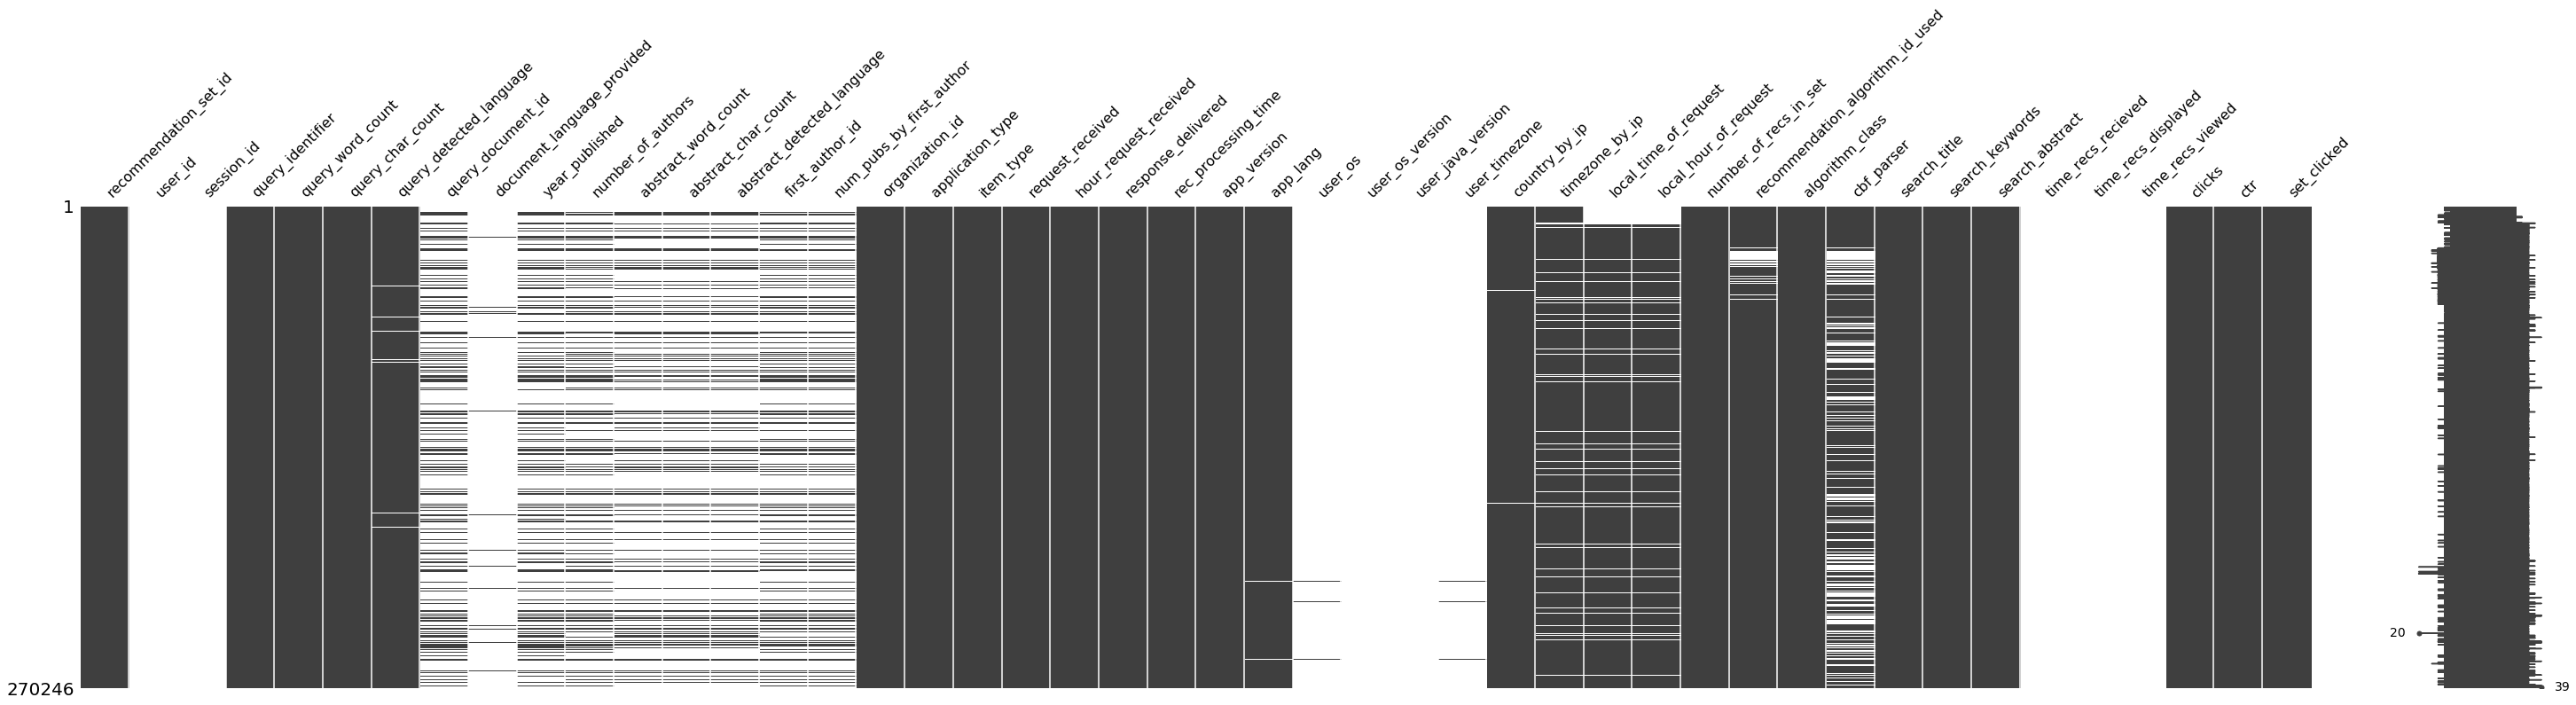

In [5]:
missingno.matrix(train, figsize = (50,10))

In [6]:
def find_missing_no(df, columns):
    missing_val = {}
    print('Number of Missing at each column')
    length_df = len(df)
    for i in columns:
        total_val = df[i].value_counts().sum()
        missing_val[i] = length_df - total_val 
    print(missing_val)

find_missing_no(train, columns=train.columns)

Number of Missing at each column
{'recommendation_set_id': 0, 'user_id': 270246, 'session_id': 270246, 'query_identifier': 0, 'query_word_count': 0, 'query_char_count': 0, 'query_detected_language': 3443, 'query_document_id': 195315, 'document_language_provided': 265819, 'year_published': 200269, 'number_of_authors': 200971, 'abstract_word_count': 213297, 'abstract_char_count': 213297, 'abstract_detected_language': 213375, 'first_author_id': 203790, 'num_pubs_by_first_author': 203790, 'organization_id': 0, 'application_type': 0, 'item_type': 101, 'request_received': 0, 'hour_request_received': 0, 'response_delivered': 0, 'rec_processing_time': 0, 'app_version': 84, 'app_lang': 1154, 'user_os': 268928, 'user_os_version': 270233, 'user_java_version': 270239, 'user_timezone': 268922, 'country_by_ip': 1280, 'timezone_by_ip': 15586, 'local_time_of_request': 24436, 'local_hour_of_request': 24436, 'number_of_recs_in_set': 0, 'recommendation_algorithm_id_used': 10677, 'algorithm_class': 0, 'cb

In [7]:
find_missing_no(test, columns=test.columns)

Number of Missing at each column
{'recommendation_set_id': 0, 'user_id': 5176, 'session_id': 5176, 'query_identifier': 0, 'query_word_count': 0, 'query_char_count': 0, 'query_detected_language': 51, 'query_document_id': 3645, 'document_language_provided': 5089, 'year_published': 3737, 'number_of_authors': 3766, 'abstract_word_count': 3994, 'abstract_char_count': 3994, 'abstract_detected_language': 3997, 'first_author_id': 3807, 'num_pubs_by_first_author': 3807, 'organization_id': 0, 'application_type': 0, 'item_type': 2, 'request_received': 0, 'hour_request_received': 0, 'response_delivered': 0, 'rec_processing_time': 0, 'app_version': 2, 'app_lang': 19, 'user_os': 5136, 'user_os_version': 5176, 'user_java_version': 5176, 'user_timezone': 5136, 'country_by_ip': 31, 'timezone_by_ip': 329, 'local_time_of_request': 509, 'local_hour_of_request': 509, 'number_of_recs_in_set': 0, 'recommendation_algorithm_id_used': 229, 'algorithm_class': 0, 'cbf_parser': 1379, 'search_title': 0, 'search_key

# EDA


In [8]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
train_df = train
test_df = test

In [9]:
train['application_type'].value_counts()

digital_library    270145
0                     101
Name: application_type, dtype: int64

In [10]:
train['item_type'].value_counts()

academic_publication    270145
Name: item_type, dtype: int64

In [11]:
train['algorithm_class'].value_counts()

content_based_filtering    193505
sentence_embeddings         53084
unknown                     10692
stereotype                   8045
same_author                  4596
random                        324
Name: algorithm_class, dtype: int64

### Dropping the columns that contain more than 50% NA values

In [12]:
train_df = train_df.drop(['user_id', 'session_id', 'query_identifier', 'query_document_id', 'document_language_provided', 
                          'year_published', 'number_of_authors', 'abstract_word_count', 'abstract_char_count', 
                          'abstract_detected_language', 'first_author_id', 'num_pubs_by_first_author', 'organization_id', 
                          'application_type', 'item_type', 'request_received', 'response_delivered', 'user_os', 
                          'user_os_version', 'user_java_version', 'user_timezone', 'timezone_by_ip', 'local_time_of_request', 
                          'time_recs_recieved', 'time_recs_displayed', 'time_recs_viewed', 'clicks', 'ctr', 'rec_processing_time', 'number_of_recs_in_set'], axis = 1)

In [13]:
train_df.shape

(270246, 16)

In [14]:
test_df = test_df.drop(['user_id', 'session_id', 'query_identifier', 'query_document_id', 'document_language_provided', 
                          'year_published', 'number_of_authors', 'abstract_word_count', 'abstract_char_count', 
                          'abstract_detected_language', 'first_author_id', 'num_pubs_by_first_author', 'organization_id', 
                          'application_type', 'item_type', 'request_received', 'response_delivered', 'user_os', 
                          'user_os_version', 'user_java_version', 'user_timezone', 'timezone_by_ip', 'local_time_of_request', 
                          'time_recs_recieved', 'time_recs_displayed', 'time_recs_viewed', 'clicks', 'ctr', 'rec_processing_time', 
                        'number_of_recs_in_set'], axis = 1)

In [15]:
test_df.shape


(5176, 16)

In [16]:
find_missing_no(train_df, columns = train_df.columns)

Number of Missing at each column
{'recommendation_set_id': 0, 'query_word_count': 0, 'query_char_count': 0, 'query_detected_language': 3443, 'hour_request_received': 0, 'app_version': 84, 'app_lang': 1154, 'country_by_ip': 1280, 'local_hour_of_request': 24436, 'recommendation_algorithm_id_used': 10677, 'algorithm_class': 0, 'cbf_parser': 76741, 'search_title': 0, 'search_keywords': 0, 'search_abstract': 0, 'set_clicked': 0}


## Handling the missing data

In [17]:
train_df['query_detected_language'].fillna(train_df['query_detected_language'].mode()[0], inplace = True)
test_df['query_detected_language'].fillna(train_df['query_detected_language'].mode()[0], inplace = True)

In [18]:
train_df['app_version'].fillna(train_df['app_version'].mode()[0], inplace = True)
test_df['app_version'].fillna(train_df['app_version'].mode()[0], inplace = True)

In [19]:
train_df['app_lang'].fillna(train_df['app_lang'].mode()[0], inplace = True)
test_df['app_lang'].fillna(train_df['app_lang'].mode()[0], inplace = True)

In [20]:
train_df['app_version'].fillna(train_df['app_version'].mode()[0], inplace = True)
test_df['app_version'].fillna(train_df['app_version'].mode()[0], inplace = True)

In [21]:
train_df['country_by_ip'].fillna(train_df['country_by_ip'].mode()[0], inplace = True)
test_df['country_by_ip'].fillna(train_df['country_by_ip'].mode()[0], inplace = True)

In [22]:
train_df['local_hour_of_request'].fillna(train_df['local_hour_of_request'].mode()[0], inplace = True)
test_df['local_hour_of_request'].fillna(train_df['local_hour_of_request'].mode()[0], inplace = True)

In [23]:
train_df['recommendation_algorithm_id_used'].fillna(train_df['recommendation_algorithm_id_used'].mode()[0], inplace = True)
test_df['recommendation_algorithm_id_used'].fillna(train_df['recommendation_algorithm_id_used'].mode()[0], inplace = True)

In [24]:
train_df['cbf_parser'].fillna(train_df['cbf_parser'].mode()[0], inplace = True)
test_df['cbf_parser'].fillna(train_df['cbf_parser'].mode()[0], inplace = True)

In [25]:
find_missing_no(train_df, columns = train_df.columns)

Number of Missing at each column
{'recommendation_set_id': 0, 'query_word_count': 0, 'query_char_count': 0, 'query_detected_language': 0, 'hour_request_received': 0, 'app_version': 0, 'app_lang': 0, 'country_by_ip': 0, 'local_hour_of_request': 0, 'recommendation_algorithm_id_used': 0, 'algorithm_class': 0, 'cbf_parser': 0, 'search_title': 0, 'search_keywords': 0, 'search_abstract': 0, 'set_clicked': 0}


In [26]:
find_missing_no(test_df, columns = test_df.columns)

Number of Missing at each column
{'recommendation_set_id': 0, 'query_word_count': 0, 'query_char_count': 0, 'query_detected_language': 0, 'hour_request_received': 0, 'app_version': 0, 'app_lang': 0, 'country_by_ip': 0, 'local_hour_of_request': 0, 'recommendation_algorithm_id_used': 0, 'algorithm_class': 0, 'cbf_parser': 0, 'search_title': 0, 'search_keywords': 0, 'search_abstract': 0, 'set_clicked': 5176}


### Creating a dataframe together to handle both values from test and train dataset while onehot and label encoding


In [27]:
together_df = pd.DataFrame()

In [28]:
train_df['flag'] = 1
test_df['flag'] = 0

In [29]:
together_df = train_df.append(test_df, ignore_index=True, sort=False)

In [30]:
query_detected_language_oh = pd.get_dummies(together_df['query_detected_language'], prefix = 'det_lang')
app_version_oh = pd.get_dummies(together_df['app_version'], prefix = 'app_ver')
country_ip_oh = pd.get_dummies(together_df['country_by_ip'], prefix = 'count_ip')
algo_class_oh = pd.get_dummies(together_df['algorithm_class'], prefix = 'alg_class')
cbf_parser_oh = pd.get_dummies(together_df['cbf_parser'], prefix = 'cbf')
app_lang_oh = pd.get_dummies(together_df['app_lang'], prefix = 'app_lang')

In [31]:
le = preprocessing.LabelEncoder()

le.fit(together_df['search_title'])
together_df['search_title'] = le.transform(together_df['search_title'])

In [32]:
le.fit(together_df['search_keywords'])
together_df['search_keywords'] = le.transform(together_df['search_keywords'])

In [33]:
le.fit(together_df['search_abstract'])
together_df['search_abstract'] = le.transform(together_df['search_abstract'])

In [34]:
cbf_parser_oh.shape

(275422, 3)

In [35]:
query_detected_language_oh.shape

(275422, 39)

In [36]:
app_version_oh.shape

(275422, 152)

In [37]:
country_ip_oh.shape

(275422, 165)

In [38]:
algo_class_oh.shape

(275422, 6)

In [39]:
find_missing_no(together_df, columns = together_df.columns)

Number of Missing at each column
{'recommendation_set_id': 0, 'query_word_count': 0, 'query_char_count': 0, 'query_detected_language': 0, 'hour_request_received': 0, 'app_version': 0, 'app_lang': 0, 'country_by_ip': 0, 'local_hour_of_request': 0, 'recommendation_algorithm_id_used': 0, 'algorithm_class': 0, 'cbf_parser': 0, 'search_title': 0, 'search_keywords': 0, 'search_abstract': 0, 'set_clicked': 5176, 'flag': 0}


In [40]:
together_df = pd.concat([together_df, query_detected_language_oh, app_version_oh, country_ip_oh, algo_class_oh], axis = 1)

In [41]:
together_df = pd.concat([together_df, cbf_parser_oh, app_lang_oh], axis = 1)

In [42]:
together_df.shape

(275422, 400)

In [43]:
together_df.drop(['query_detected_language', 'app_version', 'country_by_ip', 'algorithm_class', 'cbf_parser', 'app_lang'], axis = 1, inplace = True)

### Separating the training and testing dataset

In [44]:
train_data = together_df[together_df['flag'] == 1]
test_data = together_df[together_df['flag'] == 0]

In [45]:
train_data.drop(['flag'], axis = 1, inplace =True)

C:\Users\Dhruv\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
test_data.drop(['flag', 'set_clicked'], axis = 1, inplace=True)
test_data.set_index('recommendation_set_id')

C:\Users\Dhruv\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,query_word_count,query_char_count,hour_request_received,local_hour_of_request,recommendation_algorithm_id_used,search_title,search_keywords,search_abstract,det_lang_af,det_lang_bg,...,app_lang_ja,app_lang_nl,app_lang_no,app_lang_pt,app_lang_pt_BR,app_lang_ru,app_lang_sv,app_lang_tr,app_lang_vi,app_lang_zh
recommendation_set_id,,,,,,,,,,,,,,,,,,,,,
46914.0,18,126,16.0,15,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46961.0,5,60,17.0,15,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47012.0,8,54,17.0,15,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47181.0,9,59,22.0,15,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47240.0,10,81,0.0,15,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459307.0,13,123,13.0,13,14,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
459313.0,8,49,13.0,13,12,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
459386.0,6,49,14.0,14,11,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
train_data.set_index('recommendation_set_id')

,query_word_count,query_char_count,hour_request_received,local_hour_of_request,recommendation_algorithm_id_used,search_title,search_keywords,search_abstract,set_clicked,det_lang_af,...,app_lang_ja,app_lang_nl,app_lang_no,app_lang_pt,app_lang_pt_BR,app_lang_ru,app_lang_sv,app_lang_tr,app_lang_vi,app_lang_zh
recommendation_set_id,,,,,,,,,,,,,,,,,,,,,
46897.0,6,35,16.0,15,1,1,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
46898.0,9,53,16.0,15,1,1,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
46899.0,17,123,16.0,15,2,1,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
46902.0,14,100,16.0,15,1,1,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
46903.0,14,100,16.0,15,2,1,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459523.0,9,72,15.0,15,2,1,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
459524.0,13,122,15.0,10,11,1,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
459526.0,6,42,15.0,16,21,0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Actual Training

In [48]:
y = train_data['set_clicked']
train_data.drop(['set_clicked'], axis = 1, inplace =True)

C:\Users\Dhruv\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
train_data.shape
# find_missing_no(test_data, columns=test_data.columns)

(270246, 392)

In [50]:
test_data.shape

(5176, 392)

In [51]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_data,y, test_size=0.2)

### Testing the model creating on different regressors

In [52]:
# catboost_model = CatBoostClassifier(iterations = 2000)
# catboost_model = catboost_model.fit(X_train, y_train)

# accuracy = catboost_model.score(X_test, y_test)
# print(accuracy)
# y_test.value_counts()

In [53]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, y_train)

# acc = clf.score(X_test, y_test)
# print(acc)
# y_test.value_counts()

In [54]:
# clf = LogisticRegression()
# clf = clf.fit(X_train, y_train)
# acc = clf.score(X_test, y_test)
# print(acc)
# y_test.value_counts()

In [55]:
# clf = KNeighborsClassifier()
# clf = clf.fit(X_train, y_train)
# acc = clf.score(X_test, y_test)
# print(acc)
# y_test.value_counts()

In [56]:
# clf = GaussianNB()
# clf = clf.fit(X_train, y_train)
# acc = clf.score(X_test, y_test)
# print(acc)
# y_test.value_counts()

In [57]:
# clf = LinearSVC()
# clf = clf.fit(X_train, y_train)
# acc = clf.score(X_test, y_test)
# print(acc)
# y_test.value_counts()

In [58]:
# clf = SGDClassifier()
# clf = clf.fit(X_train, y_train)
# acc = clf.score(X_test, y_test)
# print(acc)
# y_test.value_counts()

In [59]:
# clf = GradientBoostingClassifier()
# clf = clf.fit(X_train, y_train)
# acc = clf.score(X_test, y_test)
# print(acc)
# y_test.value_counts()

In [60]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print(acc)
y_test.value_counts()

0.9780758556891767


0.0    52917
1.0     1133
Name: set_clicked, dtype: int64

# training on entire dataset

In [61]:
# catboost_model = CatBoostClassifier(iterations = 2000)
# catboost_model = catboost_model.fit(train_data, y)

In [62]:
# predictions = catboost_model.predict(test_data)

# submissions = pd.DataFrame()
# submissions['recommendation_set_id'] = output_file['recommendation_set_id']
# submissions['set_clicked'] = predictions

In [63]:
# submissions.to_csv('./JabRef_catboost_1.csv',index = False)

In [67]:
clf = DecisionTreeClassifier()
clf = clf.fit(train_data, y)

predictions = clf.predict(test_data)
submissions = pd.DataFrame()
submissions['recommendation_set_id'] = output_file['recommendation_set_id']
submissions['set_clicked'] = predictions

In [68]:
submissions['set_clicked'].value_counts()

0.0    5142
1.0      34
Name: set_clicked, dtype: int64

In [66]:
# submissions.to_csv('./JabRef_DecisionTree_1.csv',index = False)

Catboost Classifier gave 0 accuracy
Random Forest Gives 34 ones 
Decision Tree gives 233 ones